# Project 2: Predicting Flight Delays with Logistic Regression and Classification Techniques
**Project Overview**
In this project, I will be attempting to predict whether a flight will be delayed or not depending on measureable characteristics about the flight such as departure time, weather conditions, and airline specifics.

**Objectives**
- **Exploratory Data Analysis (EDA):** Conduct a thorough examination of the dataset to uncover patterns and anomalies that could influence flight delays. This step will involve visualizing key variables and exploring their relationships.
- **Model Development and Evaluation:** Implement and compare several classification models to identify the most effective approach for predicting flight delays. Models will vary in complexity, from simple logistic regression to more sophisticated ensemble methods.
- **Performance Assessment:** Investigate how adjusting the classification threshold impacts the precision, recall, and overall accuracy of the predictive models. This analysis will help fine-tune the models for practical deployment scenarios.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression

# Read in airport data

Note: This data was found by my professor on some public data repositroy related to U.S flight operations

In [27]:
# Read in flight delays
delays = pd.read_csv("./data/flightdelay.csv")
# Read in airport coordinates
airport_coord = pd.read_csv("./data/airport_coordinates.csv")

In [28]:
# Checking out the data
delays.head()

,Unnamed: 0,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,202348,1,7,0,0700-0759,1,1,29,76,Endeavor Air Inc.,10278,19857,10,John F. Kennedy International,NONE,0.0,0.0,0.0,33.0,11.41
1,4309162,8,7,1,2100-2159,11,5,3,181,Alaska Airlines Inc.,1427,24460,3,Keahole,Seattle International,0.0,0.0,0.0,88.0,9.62
2,2944942,6,2,1,1200-1259,10,2,26,154,United Air Lines Inc.,5971,53737,21,Washington Dulles International,Orlando International,0.0,0.0,0.0,87.0,4.70
3,2863511,6,7,0,1600-1659,3,3,5,76,SkyWest Airlines Inc.,9694,71188,2,Salt Lake City International,San Francisco International,0.0,0.0,0.0,86.0,15.21
4,5738468,11,1,0,0800-0859,1,2,31,76,Endeavor Air Inc.,12563,20783,10,Logan International,Greater Buffalo International,0.0,0.0,0.0,54.0,8.50


In [29]:
#Checking out the data
airport_coord.head()

,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,AFOGNAK_LAKE_AIRPORT,58.109444,-152.906667
1,BEAR_CREEK_MINING_STRIP,65.548056,-161.071667
2,LIK_MINING_CAMP,68.083333,-163.166667
3,LITTLE_SQUAW_AIRPORT,67.570000,-148.183889
4,KIZHUYAK_BAY,57.745278,-152.882778


# Part 1: Initial CLeaning
The first thing I notice is that the airport_coord data set has latitude and longitude variables that I will want to use. The Airport display names will need to be adjusted before I can merge the two datasets so though. 

In [30]:
# Making sure the airport names are the same for both datasets so I can merge
delays['DEPARTING_AIRPORT'] = delays['DEPARTING_AIRPORT'].str.lower().replace('_', ' ', regex = True)
airport_coord['DISPLAY_AIRPORT_NAME'] = airport_coord['DISPLAY_AIRPORT_NAME'].str.lower().replace('_', ' ', regex = True)

In [31]:
# Dropping all NAs in the data to help with the merge
delays.dropna(subset=['DEPARTING_AIRPORT'], inplace=True)
airport_coord.dropna(subset=['DISPLAY_AIRPORT_NAME'], inplace=True)

In [32]:
# Merging the data
delays = delays.merge(airport_coord, left_on = "DEPARTING_AIRPORT", right_on = 'DISPLAY_AIRPORT_NAME')
delays.head()

,Unnamed: 0,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,...,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,202348,1,7,0,0700-0759,1,1,29,76,Endeavor Air Inc.,...,john f. kennedy international,NONE,0.00,0.0,0.0,33.0,11.41,john f. kennedy international,40.638611,-73.776944
1,5841131,11,2,0,2100-2159,2,6,16,50,Endeavor Air Inc.,...,john f. kennedy international,Portland International Jetport,0.02,0.0,0.0,58.0,17.67,john f. kennedy international,40.638611,-73.776944
2,1103561,3,5,0,1900-1959,5,4,27,191,Delta Air Lines Inc.,...,john f. kennedy international,Fort Lauderdale-Hollywood International,0.00,0.0,0.0,59.0,6.93,john f. kennedy international,40.638611,-73.776944
3,3120058,6,3,0,0700-0759,3,2,26,150,JetBlue Airways,...,john f. kennedy international,John F. Kennedy International,0.00,0.0,0.0,82.0,10.51,john f. kennedy international,40.638611,-73.776944
4,751743,2,1,0,0800-0859,4,2,35,70,SkyWest Airlines Inc.,...,john f. kennedy international,Pittsburgh International,0.10,0.0,0.0,42.0,14.09,john f. kennedy international,40.638611,-73.776944


In [35]:
# As the objective is to predict flight delays I want to make sure the target variable: DEP_DEL15 is an integer 
delays["DEP_DEL15"] = delays["DEP_DEL15"].astype(int)

note: DEP_DEL15 = TARGET VARIABLE, Binary if delayed over 15 min, 1 is yes and 0 is no

# Part 2: Variable Exploration 
Time to see which variables associate with the likellihood of delays first and from there I will move onto making a modeling decision. 

Text(0.5, 1.0, 'Figure 1: Probability of Flight Delay by Month')

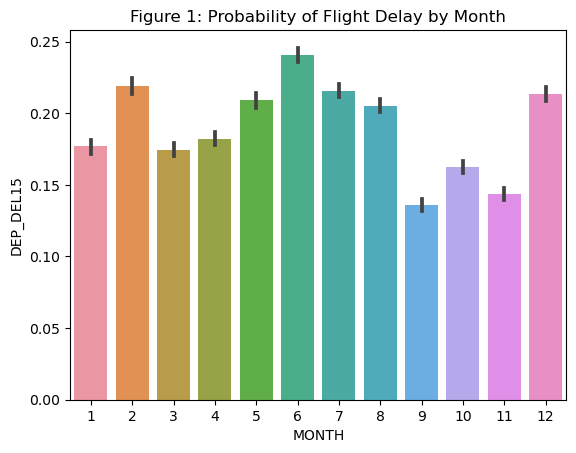

In [39]:
# Starting with a visualization to see the relationship between month of the year and probability of delay 
sns.barplot(data = delays, x = "MONTH", y = "DEP_DEL15")
plt.title("Figure 1: Probability of Flight Delay by Month")

Based on figure 1 it looks like february, May through August, and December all seem to experience higher probabilities of delay, as all their chances of delay are greater than 20%. For February and December this makes sense as Valentines and Christmas might cause an increased volume in traveling along with winter weather conditions potentially playing an effect. For May through August these are peak summer months and many people use this time to travel and with the increased volume of people traveling that also might increase the air traffic which in turn could increase flight delays.

I'm also curious if time of day makes a difference if a flight is delayed or not but I will need to change the DEP_TIME_BLK variable to a quantitative variable first.  

In [44]:
# Turns delays DEP_TIME_BLK from object to a number between 0-24 
delays['DEP_TIME_BLK'] = pd.to_datetime(delays['DEP_TIME_BLK'].str[:4], format = "%H%M").dt.hour

Text(0.5, 1.0, 'Figure 2: Probability of Flight Delay by Hour')

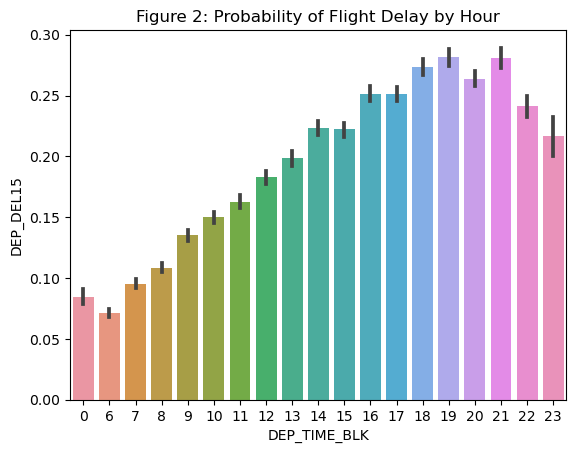

In [47]:
# Time to visualize
sns.barplot(data = delays, x = "DEP_TIME_BLK", y = "DEP_DEL15")
plt.title("Figure 2: Probability of Flight Delay by Hour") 

Based on figure 2, the probabilty of delay slightly increases each hour starting at 6am and peaking at 7pm or 9pm. This could be because people may like to fly in the afternoon or at nighttime more than in the morning which would increase airport traffic and air traffic potentially leading to higher delays during these hours. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Endeavor Air Inc.'),
  Text(1, 0, 'Delta Air Lines Inc.'),
  Text(2, 0, 'JetBlue Airways'),
  Text(3, 0, 'SkyWest Airlines Inc.'),
  Text(4, 0, 'American Airlines Inc.'),
  Text(5, 0, 'American Eagle Airlines Inc.'),
  Text(6, 0, 'Midwest Airline, Inc.'),
  Text(7, 0, 'Alaska Airlines Inc.'),
  Text(8, 0, 'Comair Inc.'),
  Text(9, 0, 'Hawaiian Airlines Inc.'),
  Text(10, 0, 'United Air Lines Inc.'),
  Text(11, 0, 'Southwest Airlines Co.'),
  Text(12, 0, 'Mesa Airlines Inc.'),
  Text(13, 0, 'Atlantic Southeast Airlines'),
  Text(14, 0, 'Frontier Airlines Inc.'),
  Text(15, 0, 'Spirit Air Lines'),
  Text(16, 0, 'Allegiant Air')])

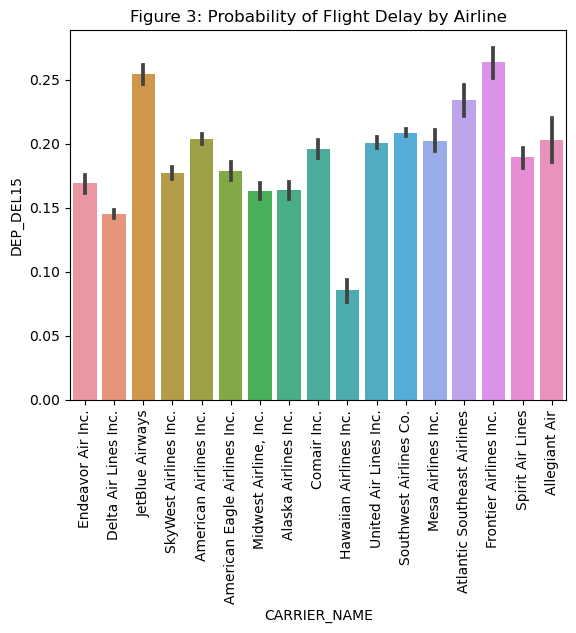

In [50]:
# I'm also curious if certain carriers have a higher flight delay rate.
sns.barplot(data = delays, x = "CARRIER_NAME", y = "DEP_DEL15")
plt.title("Figure 3: Probability of Flight Delay by Airline") 
plt.xticks(rotation = 90)

Figure 3 shows the names of the airlines on the x-axis and the probability of that airline being late on the y-axis. From this we see that most of the airlines seem to be pretty similiar along the y-axis at around 0.15 probability of being delayed. The two that broke the 0.25 probability mark were JetBlue  Airways and Frontier Airlines Inc. and the airline that was the lowest by about 0.05 then all other competitors was Hawaian Airlines Inc. This is interesting but not must use to the answer I am looking for as individual airlines have other factors to worry about and I am more curious about the general themes of all the airlines.

Text(0, 0.5, 'Probability of Delay')

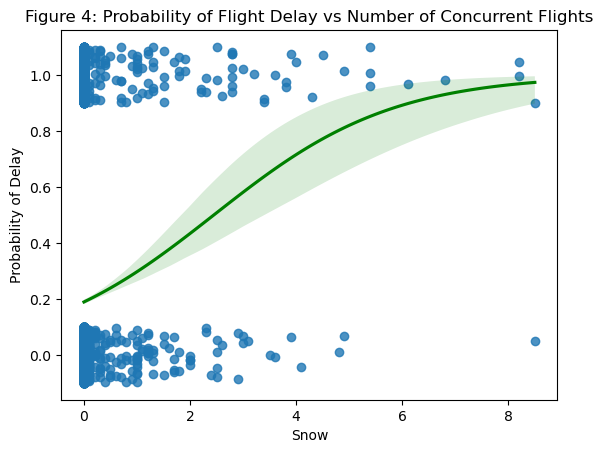

In [59]:
sampled_delays = delays.sample(n = 10000) #Takes a few minutes with the full dataset 
sns.regplot(data=sampled_delays, x='SNOW', y='DEP_DEL15', logistic=True, y_jitter = 0.1, line_kws={"color": "green"})
plt.title("Figure 4: Probability of Flight Delay vs Number of Concurrent Flights")
plt.xlabel('Snow')
plt.ylabel('Probability of Delay')

Figure 4 is a quick attempt at using a logistic regression curve to visualize the relationship between one of the continuous variables (SNOW in this case) and the target variable we're trying to predict (DEP_DEL15). This figure isn't entirely useful but it does show most of the data points had between 0-2 inches of snow. For the ranges of snow that exceeeded the 0-2 range I was expecting to see a lot more points be 1.0 on the y-axis (aka a delayed flight) but it doesn't seem as defiantly unbalanced as one might guess (see cell down below). 

In [69]:
# Shows the DEP_DEL15 counts (1 = delayed and 0 = on time) for the logistic curve where SNOW is greater than or equal to 2 inches 
filtered_delays = sampled_delays[sampled_delays['SNOW'] >= 2]
counts = filtered_delays['DEP_DEL15'].value_counts()
counts

DEP_DEL15
1    34
0    24
Name: count, dtype: int64

# Part 3: Fitting and evaluating models 
Now that I've played around with the data a bit more I'd like to start building some models to predict the probability of delay from different numbers of input features. I will then assess these models using k-fold cross validation

Setting up features for models

In [70]:
# Standardizing the continuous features in hopes that they fit the more complex models 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
continuous_features = delays[["LATITUDE", "LONGITUDE", "AWND", "TMAX", "SNOW", "PRCP", "SNWD", "CONCURRENT_FLIGHTS", "DISTANCE_GROUP", "SEGMENT_NUMBER", "NUMBER_OF_SEATS"]]
scaled_feats = scaler.fit_transform(continuous_features)

# Model 1 features 
m1_cat = pd.DataFrame(delays, columns = ["MONTH", "DAY_OF_WEEK"])
m1_scaled = pd.DataFrame(scaled_feats[:,[3]], columns = ["TMAX"])
m1_features = pd.concat([m1_cat, m1_scaled], axis = 1)

# Model 2 features
m2_cat = pd.DataFrame(delays, columns = ["MONTH"])
m2_scaled = pd.DataFrame(scaled_feats[:, 2:6], columns = ["AWND", "TMAX", "SNOW", "PRCP"])
m2_features = pd.concat([m2_cat, m2_scaled], axis = 1)

# Model 3 features
m3_features = pd.DataFrame(scaled_feats[:, 0:8], columns = ["LATITUDE", "LONGITUDE", "AWND", "TMAX", "SNOW", "PRCP", "SNWD", "CONCURRENT_FLIGHTS"])

# Model 4 Features
m4_features = pd.DataFrame(scaled_feats[:, [4]], columns = ["SNOW"])

K-folds cross validation

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

def compute_CV_error(model, X_train, Y_train):
    
    kf = KFold(n_splits=5)
    training_errors = []
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        model.fit(split_X_train, split_Y_train)

        # Training loss
        Y_train_pred = model.predict_proba(split_X_train)
        train_loss = log_loss(split_Y_train, Y_train_pred)
        training_errors.append(train_loss)

        # Validation Loss 
        Y_valid_pred = model.predict_proba(split_X_valid)
        valid_loss = log_loss(split_Y_valid, Y_valid_pred)
        validation_errors.append(valid_loss)
    
    return training_errors, validation_errors

model_m1 = LogisticRegression()
model_m2 = LogisticRegression()
model_m3 = LogisticRegression()
model_m4 = LogisticRegression()

X1 = m1_features
X2 = m2_features
X3 = m3_features
X4 = m4_features
Y = delays["DEP_DEL15"]

train_error_m1, valid_error_m1 = compute_CV_error(model_m1, X1, Y)
train_error_m2, valid_error_m2 = compute_CV_error(model_m2, X2, Y)
train_error_m3, valid_error_m3 = compute_CV_error(model_m3, X3, Y)
train_error_m4, valid_error_m4 = compute_CV_error(model_m4, X4, Y)

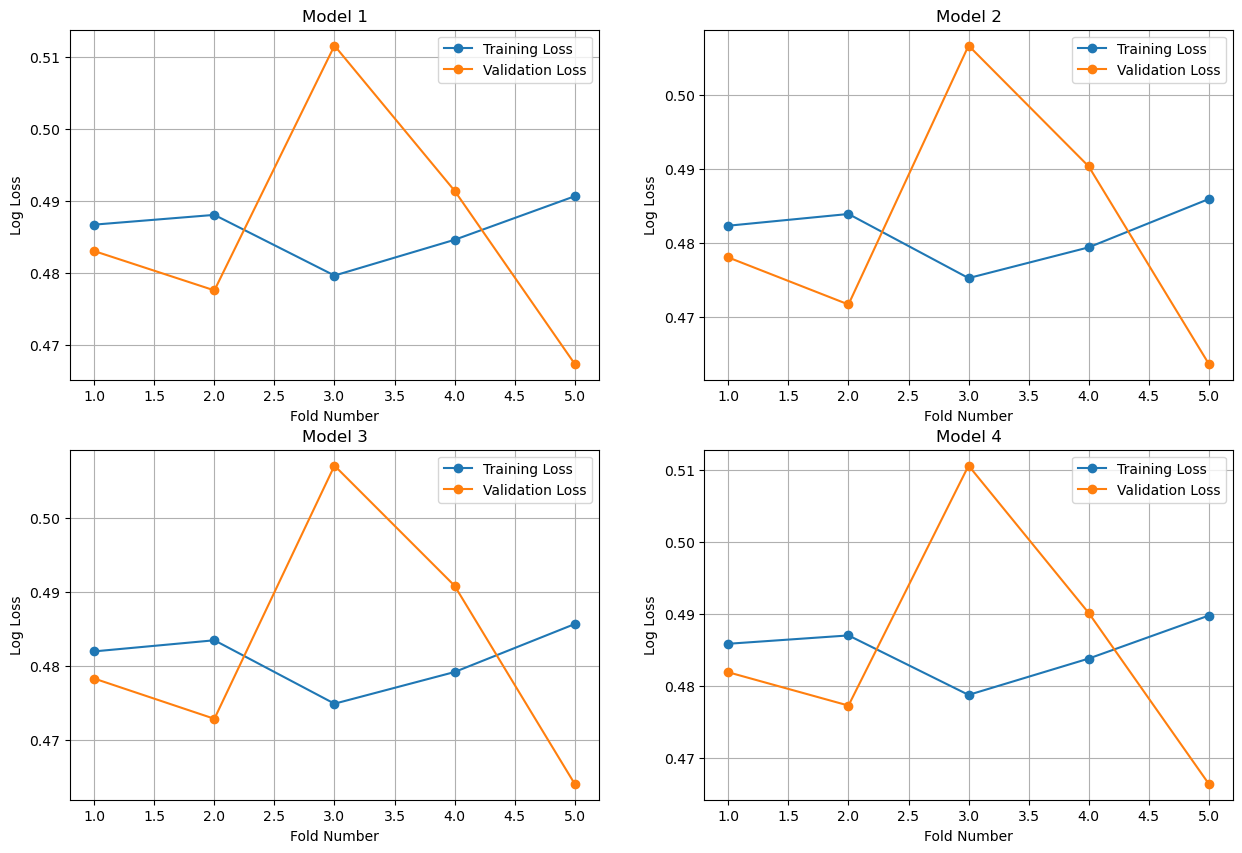

In [100]:
#Visualizing the training and validation errors for each model
# Model names for labeling
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
training_errors = [train_error_m1, train_error_m2, train_error_m3, train_error_m4]
validation_errors = [valid_error_m1, valid_error_m2, valid_error_m3, valid_error_m4]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2,  ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, ax in enumerate(axes):
    # Plot training and validation loss on each subplot
    ax.plot(range(1, 6), training_errors[i], label='Training Loss', marker='o')
    ax.plot(range(1, 6), validation_errors[i], label='Validation Loss', marker='o')
    ax.set_title(models[i])
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Log Loss')
    ax.legend()
    ax.grid(True)

In [101]:
# Average training and validation losses for each of the models 
def calculate_mean_errors(error_lists):
    """ Calculate mean errors for a list of error lists"""
    return [np.mean(errors) for errors in error_lists]

all_train_errors = [train_error_m1, train_error_m2, train_error_m3, train_error_m4]
all_validation_errors = [valid_error_m1, valid_error_m2, valid_error_m3, valid_error_m4]

# Compute mean errors
mean_train_errors = calculate_mean_errors(all_train_errors)
mean_validation_errors = calculate_mean_errors(all_validation_errors)

# Print the results
for i, (train_error, valid_error) in enumerate(zip(mean_train_errors, mean_validation_errors)):
    print(f"Average Train Log Loss for Model {i+1}: {train_error}")
    print(f"Average Validation Log Loss for Model {i+1}: {valid_error}")

Average Train Log Loss for Model 1: 0.4859562122736273
Average Validation Log Loss for Model 1: 0.4862189619241912
Average Train Log Loss for Model 2: 0.4813377557522962
Average Validation Log Loss for Model 2: 0.48205307417768084
Average Train Log Loss for Model 3: 0.48099793778364575
Average Validation Log Loss for Model 3: 0.4825895587808907
Average Train Log Loss for Model 4: 0.48507154371856204
Average Validation Log Loss for Model 4: 0.4852938809946224


All of the models fit the data just about the same but model 2 marginally fits the data best at about 0.4820 average loss. This could be because it was a more balanced number of variables compared to the other models. Model 2 used 5 variables as predictors compared to the other models which used 3, 8, and 1 predictor variables. Too many variables might cause and overfit while too little variables might cause an underfit. With such little differences in log loss between the models though it seems that all of the variables have similar predictive capabilities. Maybe this is because flight delays are pretty unpredictable and so each variable used here has an equally likely chance to predict if a flight will be delayed or not.

# Part 4
Calculating the Accuracy, precision, and recall of model 2

Predicting a 0 or a 1 (no delay or delay) using the x holdout data. Then using the y holdout data to quantify the number of true positives, true negatives, false positives, and false negatives. 

In [105]:
from sklearn.metrics import confusion_matrix
np.random.seed(25)
X_train2, X_holdout2, Y_train2, Y_holdout_2 = train_test_split(X2, Y, test_size = 0.10)

# Trained
trained = model_m2.fit(X_train2, Y_train2)
# Predcitions
Y_holdout_pred = model_m2.predict(X_holdout2)
# Confusion matrix 
cm = confusion_matrix(Y_holdout_2, Y_holdout_pred)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

# Precision or positive predictive value
PPV = TP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f"False Positive: {FPR} and False Negative: {FNR}")

False Positive: [0.99296466 0.00140503] and False Negative: [0.00140503 0.99296466]


In [106]:
accuracy = ACC
precision = PPV
recall = TPR

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = [0.81181039 0.81181039], precision = [0.81248841 0.5375    ], and recall = [0.99859497 0.00703534]


**Question:** Would this model be a good decision tool to use to decide if a flight I've booked will be delayed? 

**Response:** No I don't believe it's very useful for predicting flight delays. The recall for predicting delays is only 0.7% which is not nearly good enough for me to feel comfortable using it as a decision making tool. It's also worth seeing that the precision for predicting delays is 53.75% so even when the model predicts a delay it is only right just over half of the time. Accuracy however does seem reasonably high at 81.11% but this could be because the models ability to correctly predict no delays is so high at 99.85%. Overall the model is not useful for its intended purpose of predicting flight delays but it is pretty good at prediciting flights that won't be delayed.

**Question 4.3**
sklearn.model.predict uses a threshold of p=0.5 by default when predicting a 0 or 1 from the logistic model. Perhaps this threshold was too ambitious. Unless there are significantly different models out there very few flight delays are going to be >50% likelihood. Moving forward lets think of our model as a tool for flagging flights to watch out for instead.

First, calculate the proportion of all flights delayed in the dataset.

In [131]:
prop_delayed = np.sum(delays["DEP_DEL15"] == 1) / len(delays["DEP_DEL15"])
prop_delayed

0.18997204525771066

**Question 4.4**
This may represent a better baseline for our threshold than 0.5. Note that this will change our interpretation of a predicted class of 1; rather than a 1 representing a flight we think is likely to be delayed, a 1 will represent a flight we think has a better chance than average to be delayed.

Using our best model, we will use model.predict_proba() to

1. Return the predicted probabilties 

2. Identify which predictions have a greater than prop_delayed and classify these as 1

3. Recalculate accuracy, precision, and recall

In [112]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
predicted_probabilities = model_m2.predict_proba(X_holdout2)
# predicted_probabilities
preds_greater = (predicted_probabilities[:, 1] > prop_delayed).astype(int)

In [113]:
accuracy = accuracy_score(Y_holdout_2, preds_greater)
precision = precision_score(Y_holdout_2, preds_greater)
recall = recall_score(Y_holdout_2, preds_greater)

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = 0.634099734944215, precision = 0.23636030757964116, and recall = 0.4224476439790576


**Question 4.5**
How did lowering the threshold of the classifier change its precision and recall, and what does this mean in terms of predicting flight delays?

**Response:** Lowering the threshold of the classifer significantly lowered precision and increased recall. This means that when the model predicts a flight will be delayed, only about 23.63% of these predicted flights will actually be delayed. The models recall went up to 42.24% meaning that the model will correctly predict 42.24% of all actual delays. This makes the model more sensitive to actual delays but also more likely to have false positives. The higher recall indicates that there is less chance of missing a real delay because the model is now more adept at identifying possible delays. The downside is that more flights are incorrectly reported as delayed.

**Question 4.6**
Create a new variable representing a completely random guess for a flight delay, weighted by the observed likelihood of a delay. Calculate the accuracy, precision, and recall of your random guesses.

How does the best model with this new threshold perform compared to a completely random guess? What does this imply about the usefulness of the model as a decision-making tool?

In [132]:
n = len(Y_holdout_2)
random_guess = np.random.choice([0, 1], size = n, p = [1 - prop_delayed, prop_delayed])
accuracy = accuracy_score(Y_holdout_2, random_guess)
precision = precision_score(Y_holdout_2, random_guess)
recall = recall_score(Y_holdout_2, random_guess)
print(f"Accuracy = {accuracy}, Precision = {precision}, and Recall = {recall}")

Accuracy = 0.6926585711643962, Precision = 0.18719611021069693, and Recall = 0.18897251308900523


**Response:** In comparing accuracy, precision, and recall between a random guess and my best model, accuracy is about 6% higher in the random guess, precision is about 4% worse in the random guess, and recall is about 23% worse in the random guess. Overall it does show the model is more useful than a random guess as a 23% increase in recall is important for situations like this where predicting flight delays might be more important than a higher accuracy. The fact that a completely random guess outperformed the model at all exposes the models predictive capabilities but I would still use it over a completely random guess as a decision making tool when trying to anticipate flight delays.

**Question 4.7**
Do flight delays seem relatively easy or challenging to predict? Why?

**Response:** They seem relatively challenging to predict. The complexity seems to come from the predictive power of the variables themselves where so far in my analyses none of the variables used seemed to outperform the others in predicting if a flight would be delayed or not. Many of these factors can contribute to a flight being delayed but with no single factor or combination of them offering a strong predictive ability it makes it quite challenging to predict a flights delay. It also might be worth noting some of these variables (such as AWND or TMAX) are weather conditions which can also be quite unpredictable and so might contribute to the difficulty of making a highly predictive model. Overall, the absence of a dominant predictive variable(s) and the unpredictable key factors going into the model makes predicting flight delays challenging.



# Question 5
**Question 5.1**
Use 5-fold cross-validation to compare the fit of every one of the following univariate predictors of delay:

['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

Therefore we will be cross-validating 12 single-feature models. Then, rank the predictors in order of best to worst fit.

Next, create 8 logistic models with increasing numbers of predictors, starting with the best feature and then progressively adding the next best feature up to 8. This is called forward step-wise subset selection. If fitting problems occur at the upper range of these models, we will standardize the variables and fit up to the number of features we're able to.

Using the same threshold technique as in Q4.4, calculate the test data accuracy, precision and recall of the best model as determined by cross-validation.

In [133]:
def compute_CV_error(model, X_train, Y_train):
    
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        model.fit(split_X_train, split_Y_train)
        Y_pred = model.predict_proba(split_X_valid)
        
        error = log_loss(split_Y_valid, Y_pred)
        validation_errors.append(error)
    
    return np.mean(validation_errors)

In [134]:
# 12 models
Y = delays["DEP_DEL15"]
features = ['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

cv_errors = {}

X_train_f, X_holdout_f, Y_train_f, Y_holdout_f = train_test_split(delays[features], delays["DEP_DEL15"], test_size=0.2)

for feature in features:
    X_train = X_train_f[[feature]]
    model = LogisticRegression()
    cv_error = compute_CV_error(model, X_train, Y_train_f)
    cv_errors[feature] = cv_error

In [135]:
# Rank the predictors
ranked = sorted(cv_errors.items(), key = lambda x: x[1], reverse = True)
ranked

[('DAY_OF_WEEK', 0.4863468144652644),
 ('PLANE_AGE', 0.4863106623111954),
 ('CONCURRENT_FLIGHTS', 0.4863006592779994),
 ('TMAX', 0.4862772719836162),
 ('NUMBER_OF_SEATS', 0.4862217057184567),
 ('DISTANCE_GROUP', 0.48616321259036005),
 ('MONTH', 0.4861492063562888),
 ('SNWD', 0.4860393605192602),
 ('SNOW', 0.48527435322886775),
 ('AWND', 0.48492408028155926),
 ('PRCP', 0.48327245953667497),
 ('SEGMENT_NUMBER', 0.47993750121115825)]

In [136]:
def compute_CV_error_3(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Use standard NumPy array slicing
        # No .iloc this time
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]
        
        model.fit(split_X_train, split_Y_train)
        Y_pred = model.predict_proba(split_X_valid)
        
        error = log_loss(split_Y_valid, Y_pred)
        validation_errors.append(error)
    
    return np.mean(validation_errors)

In [137]:
# 8 models, stepwise subset selection
ranked_features = ["DAY_OF_WEEK", 'PLANE_AGE', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'DISTANCE_GROUP', 'MONTH', 'TMAX', 'SNWD', 'SNOW', 'AWND', 'PRCP', 'SEGMENT_NUMBER']
scaled = scaler.fit_transform(delays[ranked_features])

X_train_f, X_holdout_f, Y_train_f, Y_holdout_f = train_test_split(scaled, delays["DEP_DEL15"], test_size=0.2)
Y_train_f = Y_train_f.reset_index(drop = True)
avg_errors = []

for i in range(8):
    X_train_subset = X_train_f[:, :i+1]
    model = LogisticRegression()
    cv_error = compute_CV_error_3(model, X_train_subset, Y_train_f)
    avg_errors.append(cv_error)

for i, errors in enumerate(avg_errors):
    print(f"Average Log Loss for Model {i+1}: {errors}")

Average Log Loss for Model 1: 0.48607938053151756
Average Log Loss for Model 2: 0.48606871890902814
Average Log Loss for Model 3: 0.4860358705851353
Average Log Loss for Model 4: 0.4858963888747744
Average Log Loss for Model 5: 0.4857949551528115
Average Log Loss for Model 6: 0.4856583517009754
Average Log Loss for Model 7: 0.48563179244495425
Average Log Loss for Model 8: 0.4853544496502666


In [138]:
# Best model accuracy, precision, recall
best_model = LogisticRegression()
best_X_train = X_train_f[:, :8] 
best_model.fit(best_X_train, Y_train_f) 

# Predicting probabilities on the holdout set
predicted_probabilities = best_model.predict_proba(X_holdout_f[:, :8])

prop_delayed = np.mean(Y_train_f)

# Generate predictions based on the new threshold
preds_greater = (predicted_probabilities[:, 1] > prop_delayed).astype(int)

accuracy = accuracy_score(Y_holdout_f, preds_greater)
precision = precision_score(Y_holdout_f, preds_greater)
recall = recall_score(Y_holdout_f, preds_greater)

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = 0.5512166556225054, precision = 0.201459334401139, and recall = 0.458410950028347


**Question 5.2**
Was the model with the best CV score the most complex model? If yes, why might complexity not have been a problem in this case? If no, why might a simpler model outperform the full model?

**Your response:** Yes the model with all 8 predictors gave the least amount of loss which was the best CV score. This shows complexity might not have been a problem in this case. Instead, each additional predictor added meaningful information to the models ability to distinguish between delayed and non-delayed flights. The added variables didn't seem to lead to overfitting since the model improved as it became more complex. My gut tells me that these specific predictors are a good fit for the model's complexity which allow it to better reflect the underlying patterns in the flight delay data.